In [46]:
from datetime import datetime
import numpy as np
import math
import pandas as pd
from scipy.stats import mstats
from IPython.display import display
from ipython_helpers import (
    print_full
)
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [47]:
# Transform Functions
def transform_crspcs_qtrly_df(df):
    df = df[df['LINKPRIM'].isin(['P', 'C'])]
    df = df.rename(columns={
            'LPERMCO': 'PERMCO',
            'LPERMNO': 'PERMNO',
            'tic': 'TICKER',
            'cusip': 'CUSIP',
            'cshoq': 'outstanding_shares',
            'prccq': 'crspcs_share_price',
            'niq': 'net_income',
            'cheq': 'cash_and_sti',
            'atq': 'total_assets',
            'ltq': 'total_liabilities'
        })
    
    
    df.loc[:, 'lagged_date'] = df['datadate'].map(lambda x: x + relativedelta(months=2)) 
    df.loc[:, 'year'] = df['lagged_date'].dt.year 
    df.loc[:, 'month'] = df['lagged_date'].dt.month 
    df.loc[:, 'deletion_year'] = df['dldte'].dt.year 
    df.loc[:, 'deletion_month'] = df['dldte'].dt.month
    df.loc[:, 'outstanding_shares'] = df['outstanding_shares'] * math.pow(10, 6)
    df.loc[:, 'given_market_value'] = df['mkvaltq'] * math.pow(10, 6)
    df.loc[:, 'computed_market_value'] = df['outstanding_shares'] * df['crspcs_share_price']
    df.loc[:, 'crspcs_market_value'] = np.where(pd.notnull(df['given_market_value']), df['given_market_value'], df['computed_market_value'])
    df.loc[:, 'net_income'] = df['net_income'] * math.pow(10, 6)
    df.loc[:, 'cash_and_sti'] = df['cash_and_sti'] * math.pow(10, 6)
    df.loc[:, 'total_assets'] = df['total_assets'] * math.pow(10, 6)
    df.loc[:, 'total_liabilities'] = df['total_liabilities'] * 10**6
    df.loc[:, 'book_equity'] = df['total_assets'] - df['total_liabilities']
    df.loc[:, 'CUSIP'] = df['CUSIP'].astype(str).str[:-1]
    
    return df


def transform_crsp_monthly_equity_df(df):
    df = df.rename(columns={
        'SHROUT': 'outstanding_shares',
        'PRC': 'crsp_share_price',
        'sprtrn': 'sp500_index_return',
        'RET': 'equity_return'
    })   
    
    df.loc[:, 'lagged_date'] = df['date'].map(lambda x: x + relativedelta(months=1)) #2
    df.loc[:, 'year'] = df['lagged_date'].dt.year  #3
    df.loc[:, 'month'] = df['lagged_date'].dt.month  
    df.loc[:, 'outstanding_shares'] = df['outstanding_shares'] * math.pow(10, 3)  #4
    df.loc[:, 'crsp_share_price'] = df['crsp_share_price'].abs()  #5
    df.loc[:, 'crsp_market_value'] = df['outstanding_shares'] * df['crsp_share_price']  #6
    df.loc[:, 'sp500_index_return'] = pd.to_numeric(df['sp500_index_return'], errors='coerce', downcast='float')  #7 
    df.loc[:, 'equity_return'] = pd.to_numeric(df['equity_return'], errors='coerce', downcast='float')  #8

    return df


def transform_crsp_monthly_index_df(df):
    # 1) Lag the time by 1 month to ensure that information from specific month is
    # only accessible in the beginning of the next month
    df.loc[:, 'lagged_date'] = df['caldt'].map(lambda x: x + relativedelta(months=1))
    df.loc[:, 'year'] = df['lagged_date'].dt.year
    df.loc[:, 'month'] = df['lagged_date'].dt.month   
    # 2) Fix the unit of total market value by multiplying by 1000
    df.loc[:, 'totval'] = df['totval'] * math.pow(10, 3)
    df = df.rename(columns={'totval': 'sp500_market_value'})
    
    return df


def convert_qtrly_to_monthly(df):
    df_1 = df.copy()
    df_2 = df.copy()
    
    # Increment df_1's date by 1 month 
    df_1.loc[:, 'lagged_date'] = df_1['lagged_date'].map(lambda x: x + relativedelta(months=1))
    df_1.loc[:, 'year'] = df_1['lagged_date'].dt.year
    df_1.loc[:, 'month'] = df_1['lagged_date'].dt.month 
    
    # Increment df_1's date by 2 months 
    df_2.loc[:, 'lagged_date'] = df_2['lagged_date'].map(lambda x: x + relativedelta(months=2))
    df_2.loc[:, 'year'] = df_2['lagged_date'].dt.year
    df_2.loc[:, 'month'] = df_2['lagged_date'].dt.month 
    
    frames = [df, df_1, df_2]
    
    monthly_df = pd.concat(frames)
    monthly_df = monthly_df.sort_values(by=['TICKER', 'CUSIP', 'year', 'month'])
    
    return monthly_df


def transform_merged_df(df):
    df = df.rename(columns={
        'TICKER_x': 'TICKER',
        'lagged_date_x': 'lagged_date',
        'conm': 'company_name',
        'teqq': 'total_equity',    
        'outstanding_shares_x':'crspcs_outstanding_shares',
        'outstanding_shares_y':'crsp_outstanding_shares'
        })
    
            
    df.loc[:, 'company_share_price'] = np.where(pd.notnull(df['crsp_share_price']), df['crsp_share_price'], df['crspcs_share_price'])
    df.loc[:, 'company_market_value'] = np.where(pd.notnull(df['crsp_market_value']), df['crsp_market_value'], df['crspcs_market_value'])
    df.loc[:, 'is_bankrupt'] = np.where(df['dlrsn'].isin([2, 3]), True, False)
    
    return df

# Merge functions
def merge_crsp_equity_and_index_df(equity_df, index_df):
    return equity_df.merge(index_df[['sp500_market_value', 'year', 'month']], on=['year', 'month'])
    
    
def merge_crspcs_and_crsp_df(crspcs_df, crsp_df):    
    return crspcs_df.merge(crsp_df, how='left', on=['PERMNO', 'year', 'month'])


def merge_merged_df_and_sigma_df(merged_df, sigma_df):
    return merged_df.merge(sigma_df, how='left', on=['PERMNO', 'year', 'month'])
    
# Helper functions
def make_mean_df(df, var_name):
    return df.groupby(['year', 'month']).agg({var_name: 'mean'})
    
    
def replace_missing(row, mean_df, var_name):
    if pd.isnull(row[var_name]):
        return mean_df.loc[row['year'], row['month']][var_name]
    else:
        return row[var_name]

        
def make_campbell_df(df):
    print("Currently making ADJUSTED_TOTAL_ASSETS variable")
    df.loc[:, 'ADJUSTED_TOTAL_ASSETS'] = df['total_assets'] + 0.1 * (df['company_market_value'] - df['book_equity'])
    
    print("Currently making MARKET_TOTAL_ASSETS variable")
    df.loc[:, 'MARKET_TOTAL_ASSETS'] = df['company_market_value'] + df['total_liabilities']

    print("Currently making NITA variable")
    df.loc[:, 'NITA'] = df['net_income'] / df['ADJUSTED_TOTAL_ASSETS']

    print("Currently making TLTA variable")
    df.loc[:, 'TLTA'] = df['total_liabilities'] / df['ADJUSTED_TOTAL_ASSETS']
    
    print("Currently making NIMTA variable")
    df.loc[:, 'NIMTA'] = df['net_income'] / df['MARKET_TOTAL_ASSETS']
    
    print("Currently making TLMTA variable")
    df.loc[:, 'TLMTA'] = df['total_liabilities'] / df['MARKET_TOTAL_ASSETS']
    
    print("Currently making CASHMTA variable")
    df.loc[:, 'CASHMTA'] = df['cash_and_sti'] / df['MARKET_TOTAL_ASSETS']

    print("Currently making RSIZE variable")
    df.loc[:, 'RSIZE'] = np.log(df['company_market_value'] / df['sp500_market_value'])
    
    print("Currently making PRICE variable")
    df.loc[:, 'company_share_price'] = np.where(df['company_share_price'] > 15, 15, df['company_share_price'])
    df.loc[:, 'PRICE'] = np.log(df['company_share_price'])

    
    print("Currently making MB variable")
    df.loc[:, 'adjusted_book_equity'] = df['ADJUSTED_TOTAL_ASSETS'] - df['total_liabilities'] + 0.1 * (df['company_market_value'] - df['book_equity'])
    df.loc[:, 'adjusted_book_equity'] = np.where(df['adjusted_book_equity'] < 0, 1, df['adjusted_book_equity'])
    df.loc[:, 'MB'] = df['company_market_value'] / df['adjusted_book_equity']  
    
    print("Currently making EXRET variable")
    df.loc[:, 'EXRET'] = np.log(1 + df['equity_return']) - np.log(1 + df['sp500_index_return'])

    print("Currently making EXRET_AVG, NIMTA_3MONTHS, NIMTA_AVG variables")
    df = df.groupby(by=['PERMNO']).apply(make_AVG_columns)       
    df = df.reset_index(drop=True)
    
    nimta_avg_mean_df = make_mean_df(df, 'NIMTA_AVG')
    exret_avg_mean_df = make_mean_df(df, 'EXRET_AVG')
    
    print("Currently replacing missing NIMTA_AVG with cross sectional mean")
    df.loc[:, "NIMTA_AVG"] = df.apply(lambda x: replace_missing(x, nimta_avg_mean_df, 'NIMTA_AVG'), axis=1)

    print("Currently replacing missing EXRET_AVG with cross sectional mean")
    df.loc[:, "EXRET_AVG"] = df.apply(lambda x: replace_missing(x, exret_avg_mean_df, 'EXRET_AVG'), axis=1)

    return df


def make_AVG_columns(df):
    df = df.sort_values(by=['year', 'month'])
    df.loc[:, "EXRET_AVG"] = df['EXRET'].rolling(13).apply(compute_EXRET_AVG)
    df.loc[:, "NIMTA_3MONTHS"] = df['NIMTA'].rolling(4).apply(compute_NIMTA_3MONTHS)
    df.loc[:, "NIMTA_AVG"] = df['NIMTA_3MONTHS'].rolling(11).apply(compute_NIMTA_AVG)    
    
    return df


def compute_EXRET_AVG(values):
    weight = math.pow(2, -1.0/3)

    output_value = 0
    for index, value in enumerate(reversed(values[:12])):
        output_value += math.pow(weight, index) * value
    
    output_value = output_value * (1 - weight) / (1 - math.pow(weight, 12))

    return output_value


def compute_NIMTA_3MONTHS(values):
    return np.mean(values[:3])


def compute_NIMTA_AVG(values):
    weight = math.pow(2, -1.0/3)

    output_value = 0
    for index, value in enumerate(reversed(values[:10])):
        output_value += math.pow(weight, index) * value
    
    output_value = output_value * (1 - math.pow(weight, 3)) / (1 - math.pow(weight, 12))

    return output_value
    

def winsorize_df(df, var_list=None):
    """Winsorizes the variables specified in the var_list at 5th and 95th percentile
    """
    
    if var_list == None:
        var_list = [
            'CASHMTA',
            'EXRET_AVG',
            'PRICE',
            'MB',
            'NIMTA_AVG',
            'RSIZE',
            'SIGMA',
            'TLMTA'
        ]
        
    for var in var_list:
        print("Winsorizing {0} variable".format(var))
        column_name = var + '_win'
        win_df = df.dropna(subset=[var])
        win_df.loc[:, column_name] = mstats.winsorize(win_df[var], limits=(0.05, 0.05))
        df = df.join(win_df[column_name])
    
    print("Finished winsorizing variables")

    return df 

    
def get_month_diff(row):
    if row['is_bankrupt']:
        year_diff = row['deletion_year'] - row['year']
        months_diff = row['deletion_month'] - row['month']
        if year_diff > 0:
            months_diff = 12 * year_diff + months_diff 

        return months_diff 
    else:
        return np.nan
    
    
def make_month_diff_column(df):
    df = df.sort_values(by=['PERMNO', 'year', 'month'])
    df.loc[:, 'month_diff'] = df.apply(lambda row: get_month_diff(row), axis=1)
    
    return df

    
def make_bankruptcy_column(df, month):
    df = df.sort_values(by=['PERMNO', 'year', 'month'])
    df.loc[:, 'is_bankrupt_within_'+str(month)] = np.where(df['month_diff'] <= month, True, False)
    
    return df 
    
    
def make_bankruptcy_df(df, month):
    df = make_bankruptcy_column(df, month)
    bankrupt_df = df[df['is_bankrupt_within_'+str(month)] == True]
    bankrupt_series = bankrupt_df.duplicated(subset=['PERMNO']).sort_index()
    exit_index = bankrupt_series[bankrupt_series == True]
    # Only keep the first bankruptcy observation for each firm and remove all the later observations 
    df = df[~df.index.isin(exit_index.index)]
    
    return df 
    
    
# Filter functions
def filter_exchange_df(df):
    """Filter for only stocks in NYSE, American Stock Exchange, and NASDAQ
    Stock Exchange Codes
    11 - NYSE
    12 - American Stock Exchange
    14 - NASDAQ-NMS
    """
    return df[df['exchg'].isin([11, 12, 14])]


def get_industry_code(code_int):
    """Helper functions for filter_industry_df
    """
    if np.isnan(code_int):
        return 0
    else:
        code_int = int(code_int)
        code_str = str(code_int)
        if len(code_str) == 3:
            industry_code = int(code_str[0])
        else:
            industry_code = int(code_str[:2])

    return industry_code


def filter_industry_df(df):
    """Filter out finance, industry, real estate, and nonclassifiable industries
    
    SIC Codes Reference: https://www.osha.gov/pls/imis/sic_manual.html
    60 - Depository Institutions
    61 - Non-depository Institutions
    62 - Security and Commodity Brokers, Dealers, Exchanges, and Services
    63 - Insurance Carriers
    64 - Insurance Agents, Brokers, and Services
    65 - Real Estate
    67 - Holding and Other Investment Offices
    99 - Nonclassifiable establishments
    """
    df.loc[:, 'sic_code'] = df['sic'].map(lambda x: get_industry_code(x))
    industry_filter = [60, 61, 62, 63, 64, 65, 67, 99]
    
    return df[~df['sic_code'].isin(industry_filter)]


# Check functions
def get_bankruptcy_count(df):
    df = df.drop_duplicates(subset=['PERMNO'])
    return df[df['is_bankrupt'] == True].shape


def get_last_observation_df(df):
    df = df[df['is_bankrupt'] == True]
    df = df.sort_values(by=['PERMNO', 'year', 'month'])
    df = df.drop_duplicates(subset=['PERMNO'], keep='last')

    return df


# I/O functions
def make_simple_campbell_df(df, month):
    df = df[[
            'PERMNO',
            'datadate',
            'lagged_date',
            'year',
            'month',
            'company_name',
            'CASHMTA_win',
            'EXRET_AVG_win',
            'MB_win',
            'NIMTA_AVG_win',
            'PRICE_win',
            'RSIZE_win',
            'SIGMA_win',
            'TLMTA_win',
            'month_diff',
            'is_bankrupt',
            'is_bankrupt_within_'+str(month),
            'dldte',
            'deletion_year',
            'deletion_month'          
        ]]
    
    return df


# Read Data

In [48]:
crspcs_qtrly_df = pd.read_csv("../Data/original_data/crsp_cs_merged_data_1961_2016.csv", parse_dates=['datadate', 'dldte'])

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
crsp_monthly_equity_df = pd.read_csv("../Data/original_data/crsp_monthly_equity_1961_2015.csv", parse_dates=['date'])

In [ ]:
crsp_monthly_index_df = pd.read_csv("../Data/original_data/crsp_monthly_index_1961_2015.csv", parse_dates=['caldt'])

In [ ]:
SIGMA_df = pd.read_csv("../Data/campbell_data/campbell_SIGMA.csv",
    usecols=['PERMNO', 'year', 'month', 'SIGMA'],
    dtype={
        'PERMNO': np.int32,
        'year': np.int32,  
        'month': np.int32,
        'SIGMA': np.float64,
    }                                   
)

# Transform Data - Pre-Merge

In [49]:
transformed_crspcs_qtrly_df = transform_crspcs_qtrly_df(crspcs_qtrly_df)

In [ ]:
transformed_crsp_monthly_equity_df = transform_crsp_monthly_equity_df(crsp_monthly_equity_df)

In [ ]:
transformed_crsp_monthly_index_df = transform_crsp_monthly_index_df(crsp_monthly_index_df)

In [ ]:
crspcs_monthly_df = convert_qtrly_to_monthly(transformed_crspcs_qtrly_df)

# Merge Data  

In [ ]:
merged_crsp_df = merge_crsp_equity_and_index_df(transformed_crsp_monthly_equity_df, transformed_crsp_monthly_index_df)

In [ ]:
merged_df = merge_crspcs_and_crsp_df(crspcs_monthly_df, merged_crsp_df)

In [ ]:
merged_df = merge_merged_df_and_sigma_df(merged_df, SIGMA_df)

# Transform Data - Post-Merge

In [ ]:
transformed_merged_df = transform_merged_df(merged_df)

In [ ]:
transformed_merged_df[transformed_merged_df['TICKER'] == 'AAPL']

# Make Variables

In [ ]:
campbell_df = make_campbell_df(transformed_merged_df)

In [ ]:
winsorized_campbell_df = winsorize_df(campbell_df)

In [ ]:
winsorized_campbell_df_sorted = winsorized_campbell_df.sort_values(by=['PERMNO', 'fyearq', 'fqtr', 'year', 'month'])

In [ ]:
winsorized_campbell_df_sorted.to_csv("../Data/campbell_data/winsorized_annual_campbell_df.csv")

In [4]:
winsorized_campbell_df_sorted = pd.read_csv("../Data/campbell_data/winsorized_annual_campbell_df.csv")

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,8,17,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Filter Data

In [5]:
filtered_industry_df = filter_industry_df(winsorized_campbell_df_sorted)

In [6]:
month_diff_df = make_month_diff_column(filtered_industry_df)

In [7]:
non_neg_month_diff_df = month_diff_df.drop(month_diff_df[month_diff_df['month_diff'] < 0].index)

# Create monthly, quarterly, annual data

In [8]:
monthly_campbell_df = non_neg_month_diff_df.sort_values(by=['PERMNO', 'fyearq', 'fqtr', 'year', 'month'])

In [9]:
quarterly_campbell_df = monthly_campbell_df.drop_duplicates(subset=['PERMNO', 'fyearq', 'fqtr'], keep='first')

In [10]:
annual_campbell_df = quarterly_campbell_df.drop_duplicates(subset=['PERMNO', 'year'], keep='last')

# Mark bankruptcies dataframes

In [17]:
monthly_campbell_df_0 = make_bankruptcy_df(monthly_campbell_df, 0)
monthly_campbell_df_6 = make_bankruptcy_df(monthly_campbell_df, 6)
monthly_campbell_df_12 = make_bankruptcy_df(monthly_campbell_df, 12)
monthly_campbell_df_24 = make_bankruptcy_df(monthly_campbell_df, 24)
monthly_campbell_df_36 = make_bankruptcy_df(monthly_campbell_df, 36)


In [11]:
quarterly_campbell_df_6 = make_bankruptcy_df(quarterly_campbell_df, 6)
quarterly_campbell_df_12 = make_bankruptcy_df(quarterly_campbell_df, 12)
quarterly_campbell_df_24 = make_bankruptcy_df(quarterly_campbell_df, 24)
quarterly_campbell_df_36 = make_bankruptcy_df(quarterly_campbell_df, 36)

In [18]:
annual_campbell_df_12 = make_bankruptcy_df(annual_campbell_df, 12)
annual_campbell_df_24 = make_bankruptcy_df(annual_campbell_df, 24)
annual_campbell_df_36 = make_bankruptcy_df(annual_campbell_df, 36)

# Check Data

In [14]:
last_annual_observation_df = get_last_observation_df(a nnual_campbell_df)
last_annual_observation_df['month_diff'].describe()

count    1227.000000
mean       28.095355
std        36.885541
min         0.000000
25%        13.000000
50%        18.000000
75%        29.000000
max       358.000000
Name: month_diff, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17724bf50>]], dtype=object)

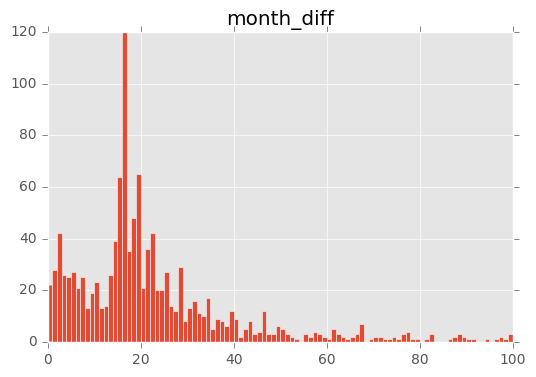

In [15]:
last_annual_observation_df.hist(column=['month_diff'], range=[0, 100], bins=100)

In [13]:
last_monthly_observation_df = get_last_observation_df(monthly_campbell_df)
last_monthly_observation_df['month_diff'].describe()

count    1227.000000
mean       26.258354
std        36.783427
min         0.000000
25%        11.000000
50%        16.000000
75%        27.000000
max       356.000000
Name: month_diff, dtype: float64

In [24]:
default_df_12 = annual_campbell_df_12[annual_campbell_df_12['is_bankrupt_within_12'] == True]

In [27]:
default_df_24 = annual_campbell_df_24[annual_campbell_df_24['is_bankrupt_within_24'] == True]

In [23]:
default_df_36 = annual_campbell_df_36[annual_campbell_df_36['is_bankrupt_within_36'] == True]

In [29]:
print(default_df_12.shape)
print(default_df_24.shape)
print(default_df_36.shape)

(298, 96)
(834, 96)
(1005, 96)


In [45]:
annual_campbell_df[annual_campbell_df['PERMNO'] == 58879]

,Unnamed: 0,GVKEY,LINKPRIM,LIID,LINKTYPE,PERMNO,PERMCO_x,LINKDT,LINKENDDT,datadate,...,CASHMTA_win,EXRET_AVG_win,PRICE_win,MB_win,NIMTA_AVG_win,RSIZE_win,SIGMA_win,TLMTA_win,sic_code,month_diff
1405380,1405380,8065,C,1,LU,58879,3318,19790131,19870923,1981-08-31,...,NaN,0.003264,0.693147,NaN,0.025192,-11.503312,0.124878,NaN,13,405.0
1405392,1405392,8065,C,1,LU,58879,3318,19790131,19870923,1982-08-31,...,0.021042,-0.014068,0.523248,2.451541,0.020132,-11.735915,0.163792,0.314314,13,393.0
1405404,1405404,8065,C,1,LU,58879,3318,19790131,19870923,1983-08-31,...,0.012715,-0.057910,0.405465,2.207749,0.043489,-11.355499,0.218772,0.346071,13,381.0
1405416,1405416,8065,C,1,LU,58879,3318,19790131,19870923,1984-08-31,...,0.025440,-0.036263,0.060625,1.667894,-0.004996,-11.862749,0.150634,0.499665,13,369.0
1405428,1405428,8065,C,1,LU,58879,3318,19790131,19870923,1985-08-31,...,0.005538,0.054021,0.283772,1.955233,-0.003656,-11.706976,0.133226,0.484772,13,357.0
1405440,1405440,8065,C,1,LU,58879,3318,19790131,19870923,1986-08-31,...,0.009014,-0.055716,-0.105361,1.405530,-0.055826,-12.740873,0.209467,0.688396,13,345.0
1405452,1405452,8065,C,1,LU,58879,3318,19790131,19870923,1987-08-31,...,NaN,-0.017806,-0.105361,NaN,-0.006237,NaN,NaN,NaN,13,333.0


# Save Data

In [ ]:
final_df.to_csv("../Data/campbell_data/complete_annual_campbell_df.csv")

In [15]:
simple_monthly_campbell_df_0 = make_simple_campbell_df(monthly_campbell_df_0, 0)
simple_monthly_campbell_df_6 = make_simple_campbell_df(monthly_campbell_df_6, 6)
simple_monthly_campbell_df_12 = make_simple_campbell_df(monthly_campbell_df_12, 12)
simple_monthly_campbell_df_24 = make_simple_campbell_df(monthly_campbell_df_24, 24)
simple_monthly_campbell_df_36 = make_simple_campbell_df(monthly_campbell_df_36, 36)

In [16]:
simple_quarterly_campbell_df_6 = make_simple_campbell_df(quarterly_campbell_df_6, 6)
simple_quarterly_campbell_df_12 = make_simple_campbell_df(quarterly_campbell_df_12, 12)
simple_quarterly_campbell_df_24 = make_simple_campbell_df(quarterly_campbell_df_24, 24)
simple_quarterly_campbell_df_36 = make_simple_campbell_df(quarterly_campbell_df_36, 36)

In [17]:
simple_annual_campbell_df_12 = make_simple_campbell_df(annual_campbell_df_12, 12)
simple_annual_campbell_df_24 = make_simple_campbell_df(annual_campbell_df_24, 24)
simple_annual_campbell_df_36 = make_simple_campbell_df(annual_campbell_df_36, 36)

In [24]:
simple_monthly_campbell_df_0.to_csv("../../../../Development/econ985/campbell_data/simple_monthly_campbell_df_0.csv")

In [25]:
simple_monthly_campbell_df_6.to_csv("../../../../Development/econ985/campbell_data/simple_monthly_campbell_df_6.csv")

In [26]:
simple_monthly_campbell_df_12.to_csv("../../../../Development/econ985/campbell_data/simple_monthly_campbell_df_12.csv")

In [27]:
simple_monthly_campbell_df_24.to_csv("../../../../Development/econ985/campbell_data/simple_monthly_campbell_df_24.csv")

In [28]:
simple_monthly_campbell_df_36.to_csv("../../../../Development/econ985/campbell_data/simple_monthly_campbell_df_36.csv")

In [29]:
simple_quarterly_campbell_df_6.to_csv("../../../../Development/econ985/campbell_data/simple_quarterly_campbell_df_6.csv")

In [30]:
simple_quarterly_campbell_df_12.to_csv("../../../../Development/econ985/campbell_data/simple_quarterly_campbell_df_12.csv")

In [31]:
simple_quarterly_campbell_df_24.to_csv("../../../../Development/econ985/campbell_data/simple_quarterly_campbell_df_24.csv")

In [32]:
simple_quarterly_campbell_df_36.to_csv("../../../../Development/econ985/campbell_data/simple_quarterly_campbell_df_36.csv")

In [21]:
simple_annual_campbell_df_12.to_csv("../../../../Development/econ985/campbell_data/simple_annual_campbell_df_12.csv")

In [22]:
simple_annual_campbell_df_24.to_csv("../../../../Development/econ985/campbell_data/simple_annual_campbell_df_24.csv")

In [23]:
simple_annual_campbell_df_36.to_csv("../../../../Development/econ985/campbell_data/simple_annual_campbell_df_36.csv")